In [1]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#import matplotlib
#matplotlib.rcParams['figure.figsize'] = (15.0, 7.0)

from model_tools import woe_line, woe_stab, WoEFiller, crosstab
from IPython.display import display, Markdown

# Загрузим датасет

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Data/df_seminar_logreg_hw.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194366 entries, 0 to 194365
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   application_rk                194366 non-null  int64  
 1   crm_income_dt                 194366 non-null  object 
 2   request_amt                   54418 non-null   float64
 3   bki_flg                       194366 non-null  int64  
 4   no_due_and_short_history_flg  159377 non-null  float64
 5   outstanding_rate              126363 non-null  float64
 6   num_active_credits            159377 non-null  float64
 7   num_status_no_due             159377 non-null  float64
 8   balance_sum                   159377 non-null  float64
 9   due_chance                    159377 non-null  float64
 10  mfo_flg                       159377 non-null  float64
 11  num_fresh_mfo                 159377 non-null  float64
 12  num_month_to_due              159377 non-nul

In [5]:
# техническое поле - месяц прихода заявки в систему
df['month_dt'] = df['crm_income_dt'].astype('datetime64[M]')

## Разобъем выборку на Train/Validation/Test

**Задание 1**

**На одном графике нарисуйте количество заявок в каждом месяце и `bad rate`. Части выборки должны быть окрашены в разные цвета.**

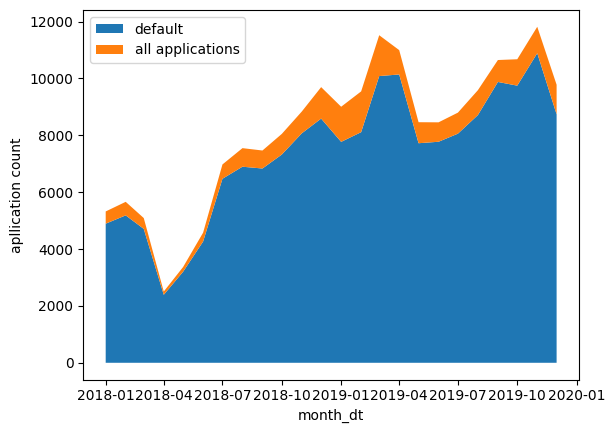

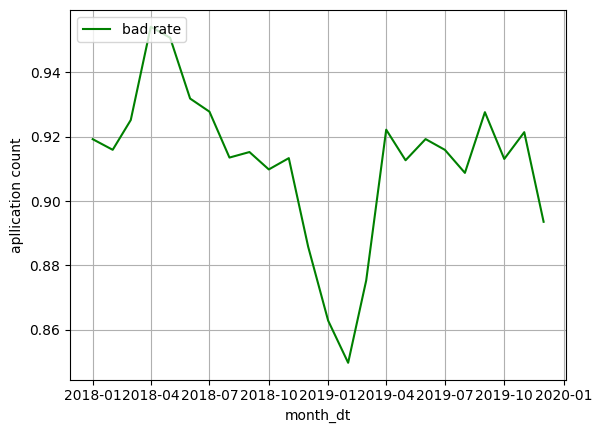

In [6]:
#df['month'] = df['month_dt'].dt.month
df_count = df['month_dt'].groupby([df['d4p12'], df['month_dt']], group_keys=True).count()
indexes = pd.Series(df_count[0].index)

plt.fill_between(indexes, df_count[0], label="default")
plt.fill_between(indexes, df_count[0], df_count[0]+ df_count[1], label="all applications")
plt.xlabel("month_dt")
plt.ylabel("apllication count")
plt.legend(loc="upper left")
plt.show()

plt.plot(indexes, df_count[0]/(df_count[0]+ df_count[1]), label="bad rate", color='g')
plt.xlabel("month_dt")
plt.ylabel("apllication count")
plt.legend(loc="upper left")
plt.grid()
plt.show()

# Построение модели

**Основное задание**

**Постройте собственную модель логистической регресии, с помощью рассмотренных на семинаре методов, используя любые признаки из датасета.**

* Критерии успешного выполнения
 - Проведены Univariate и Multivariate анализы
 - В модель входят минимум 3 новых признака
 - `ROC AUC` модели превосходит 0.692 на `Train (Seminar_2)` и 0.674 на `Test`
 - Умение интерпретировать свою модель (рассказать про самые сильные признаки, их влияние на целевую переменную)
 
Особенно приветствуются эксперементы с преобразованиями признаков / создание новых!

<font color='red'> Запрещено обучаться на `Test` выборке! </font>

Итак, алгоритм построения модели Логистической регресии выглядит следующим образом:
1. Univariate-анализ
*   Преобразовываем категориальные признаки
*   Анализ IV: исключаем слабые признаки
*   Анализ стабильности: оставляемя стабильные по *   WoE и распределению признаки
*   Анализ линейности: преобразовываем признаки, оставляем линейные
*   Анализ распределений: обрабатываем выбросы
*   Обработка null: добавляем флаги null-ов, если нужны; заполняем пропущенные значения
2. Multivariate-анализ
*   Исследуем корреляции: из коррелирующих оставляем самые сильные
*   Экспериментируем с моделью: отбор признаков, разные сегментации
*   Приводим признаки к одному масштабу
*   Обучаем модель логистической регрессии
*   Анализ линейности финальной модели
*   Анализ стабильности модели по WoE
*   Анализ стабильности по IV/ROC AUC

In [7]:
# обработка категориальных признаков

cat_features = []

for column_name in df.columns:
  check_df = df[column_name].value_counts()
  '''if len(check_df) == 2:
    # делаем признак категориальным, если в нем всего 2 вида значений
    df[column_name] = (df[column_name] == df.loc[0, column_name]).astype(int)'''
  if 1 < len(check_df) < 10 and column_name != "d4p12":
    # сохраняем признак список категориальных, если в нем от 2 до 10 видов значений, для OneHotEncoding
    cat_features.append(column_name)

# OneHotEncoding
df = pd.get_dummies(df,
        prefix=cat_features,
        dummy_na=True,
        columns=cat_features)

feature_names = list(df.columns)

# удаляем технические поля, таргет
feature_names.remove('application_rk')
feature_names.remove('d4p12')
feature_names.remove('month_dt')
feature_names.remove('crm_income_dt')

feature_names

['request_amt',
 'outstanding_rate',
 'num_active_credits',
 'num_status_no_due',
 'balance_sum',
 'due_chance',
 'num_fresh_mfo',
 'bki_score',
 'age',
 'telecom1_score',
 'telecom2_score',
 'partner1_score',
 'debet_score',
 'bki_flg_0.0',
 'bki_flg_1.0',
 'bki_flg_nan',
 'no_due_and_short_history_flg_0.0',
 'no_due_and_short_history_flg_1.0',
 'no_due_and_short_history_flg_nan',
 'mfo_flg_0.0',
 'mfo_flg_1.0',
 'mfo_flg_nan',
 'num_month_to_due_0.0',
 'num_month_to_due_1.0',
 'num_month_to_due_2.0',
 'num_month_to_due_3.0',
 'num_month_to_due_nan',
 'marital_status_cd_CIV',
 'marital_status_cd_DIV',
 'marital_status_cd_DLW',
 'marital_status_cd_MAR',
 'marital_status_cd_UNM',
 'marital_status_cd_WID',
 'marital_status_cd_nan',
 'gender_cd_F',
 'gender_cd_M',
 'gender_cd_nan',
 'education_level_cd_-1.0',
 'education_level_cd_0.0',
 'education_level_cd_1.0',
 'education_level_cd_2.0',
 'education_level_cd_nan',
 'job_type_cd_БИЗНЕС',
 'job_type_cd_БЮДЖЕТ',
 'job_type_cd_ПЛОХАЯ',
 'job

In [8]:
# выбор разбиения на трейн и валидацию

test_mask = (df.month_dt >= '2019-07-01') & (df.month_dt <= '2019-12-01')
validation_mask = (df.month_dt >= '2019-05-01') & (df.month_dt <= '2019-06-01')

df['sample_part'] = 'Train'
df.loc[validation_mask, 'sample_part'] = 'Validation'
df.loc[test_mask, 'sample_part'] = 'Test'

df['sample_part'].value_counts()

Train         116151
Test           61299
Validation     16916
Name: sample_part, dtype: int64

In [9]:
# анализ IV : IV < 0.01 - не обладает прогностической способностью;
weak_features = []
for feature_name in feature_names:
  display(Markdown('<h2>' + feature_name + '<h2>'))
  res = woe_line(
    var=df.loc[df.sample_part == 'Train'][feature_name],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm=feature_name,
    target_nm='d4p12',
    plot_line=False,
    plot_hist=False
  )
  if res['IV'] < 0.01:
    feature_names.remove(feature_name)
    weak_features.append(feature_name)
weak_features

<h2>request_amt<h2>

Удалено 78823 строк с нуллами, осталось 37328
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
 Wrong objects for 97400: total 1, target 0
 Wrong objects for 99000: total 1, target 0
 Wrong objects for 100440: total 1, target 1
 Wrong objects for 101000: total 1, target 1
 Wrong objects for 105000: total 2, target 0
 Wrong objects for 107000: total 1, target 0
 Wrong objects for 108000: total 1, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>outstanding_rate<h2>

Удалено 41722 строк с нуллами, осталось 74429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_active_credits<h2>

Удалено 21717 строк с нуллами, осталось 94434
 Wrong objects for [14; 20]: total 3, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_status_no_due<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>balance_sum<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>due_chance<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_fresh_mfo<h2>

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>bki_score<h2>

Удалено 2254 строк с нуллами, осталось 113897


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>age<h2>

Удалено 2437 строк с нуллами, осталось 113714


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>telecom1_score<h2>

Удалено 94705 строк с нуллами, осталось 21446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>telecom2_score<h2>

Удалено 23867 строк с нуллами, осталось 92284


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>partner1_score<h2>

Удалено 26015 строк с нуллами, осталось 90136


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>debet_score<h2>

Удалено 87202 строк с нуллами, осталось 28949


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>bki_flg_0.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>bki_flg_1.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>bki_flg_nan<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2
n_buckets 2 reduced to 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/content/model_tools.py:338: RuntimeWarning: divide by zero encountered in double_scalars
  R_sqr = 1 - np.sum(obj_count * (woe - logreg) ** 2) / (


<h2>no_due_and_short_history_flg_1.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>no_due_and_short_history_flg_nan<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>mfo_flg_0.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>mfo_flg_1.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>mfo_flg_nan<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_month_to_due_0.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_month_to_due_2.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>num_month_to_due_nan<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>marital_status_cd_CIV<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>marital_status_cd_DLW<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2
 Wrong objects for 1: total 2, target 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>marital_status_cd_UNM<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>marital_status_cd_WID<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>gender_cd_F<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>gender_cd_M<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>gender_cd_nan<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>education_level_cd_0.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>education_level_cd_1.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>education_level_cd_2.0<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>job_type_cd_БИЗНЕС<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>job_type_cd_ПЛОХАЯ<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>job_type_cd_ХОРОШАЯ<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


<h2>job_type_cd_nan<h2>

n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2
n_buckets 2 reduced to 1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/content/model_tools.py:338: RuntimeWarning: divide by zero encountered in double_scalars
  R_sqr = 1 - np.sum(obj_count * (woe - logreg) ** 2) / (


['bki_flg_nan',
 'num_month_to_due_0.0',
 'num_month_to_due_2.0',
 'marital_status_cd_CIV',
 'marital_status_cd_DLW',
 'marital_status_cd_WID',
 'gender_cd_nan',
 'education_level_cd_2.0',
 'job_type_cd_БИЗНЕС',
 'job_type_cd_ПЛОХАЯ',
 'job_type_cd_nan']

In [ ]:
# Анализ стабильности по WOE и распределению
for feature_name in feature_names:
  display(Markdown('<h2>' + feature_name + '<h2>'))
  woe_stab(
    var=df[feature_name],
    Nvar=2,
    time=df['month_dt'],
    bad=df['d4p12'],
    varname=feature_name,
    target='d4p12'
)

In [ ]:
feature_names

['request_amt',
 'outstanding_rate',
 'num_active_credits',
 'num_status_no_due',
 'balance_sum',
 'due_chance',
 'num_fresh_mfo',
 'bki_score',
 'age',
 'telecom1_score',
 'telecom2_score',
 'partner1_score',
 'debet_score',
 'bki_flg_0.0',
 'bki_flg_1.0',
 'no_due_and_short_history_flg_0.0',
 'no_due_and_short_history_flg_1.0',
 'no_due_and_short_history_flg_nan',
 'mfo_flg_0.0',
 'mfo_flg_1.0',
 'mfo_flg_nan',
 'num_month_to_due_1.0',
 'num_month_to_due_3.0',
 'num_month_to_due_nan',
 'marital_status_cd_DIV',
 'marital_status_cd_MAR',
 'marital_status_cd_UNM',
 'marital_status_cd_nan',
 'gender_cd_F',
 'gender_cd_M',
 'education_level_cd_-1.0',
 'education_level_cd_0.0',
 'education_level_cd_1.0',
 'education_level_cd_nan',
 'job_type_cd_БЮДЖЕТ',
 'job_type_cd_ПРОЧЕЕ',
 'job_type_cd_ХОРОШАЯ']

In [ ]:
# удаляем нестабильные по WOE признаки
unstab_features = ['request_amt', 'num_active_credits', 
                   'bki_flg_0.0', 'bki_flg_1.0', 'mfo_flg_0.0', 'mfo_flg_nan',
                   'no_due_and_short_history_flg_0.0', 'no_due_and_short_history_flg_nan',
                   'num_month_to_due_1.0', 'num_month_to_due_nan', 
                   'gender_cd_M',
                   'education_level_cd_-1.0', 'education_level_cd_nan', 'job_type_cd_ПРОЧЕЕ']
for unstab_feature_name in unstab_features:
  feature_names.remove(unstab_feature_name)
feature_names

['outstanding_rate',
 'num_status_no_due',
 'balance_sum',
 'due_chance',
 'num_fresh_mfo',
 'bki_score',
 'age',
 'telecom1_score',
 'telecom2_score',
 'partner1_score',
 'debet_score',
 'no_due_and_short_history_flg_1.0',
 'mfo_flg_1.0',
 'num_month_to_due_3.0',
 'marital_status_cd_DIV',
 'marital_status_cd_MAR',
 'marital_status_cd_UNM',
 'marital_status_cd_nan',
 'gender_cd_F',
 'education_level_cd_0.0',
 'education_level_cd_1.0',
 'job_type_cd_БЮДЖЕТ',
 'job_type_cd_ХОРОШАЯ']

In [ ]:
# анализ линейности

for feature_name in feature_names:
  display(Markdown('<h2>' + feature_name + '<h2>'))
  res = woe_line(
    var=df.loc[df.sample_part == 'Train'][feature_name],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm=feature_name,
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )
  print(res)

Удалено 41722 строк с нуллами, осталось 74429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



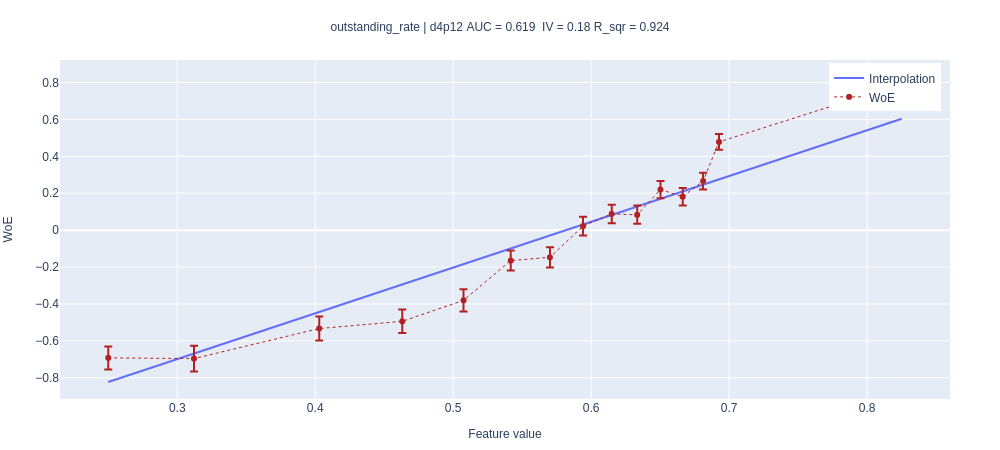

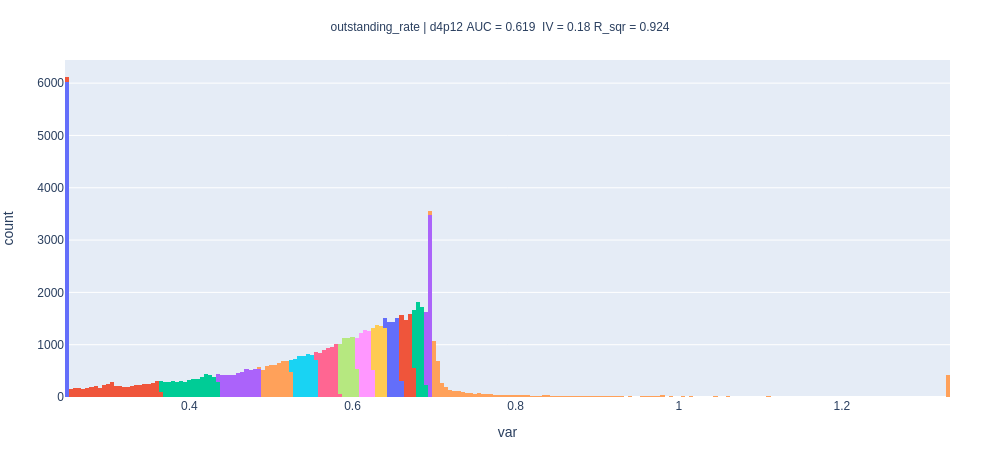

In [ ]:
left_bound = 0.25
right_bound = np.quantile(np.sqrt(df.loc[df.sample_part == 'Train']['outstanding_rate']).dropna(), 0.99)

woe_line(
    var=np.clip(np.log1p(df.loc[df.sample_part == 'Train']['outstanding_rate']), left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='outstanding_rate',
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )

df['outstanding_rate'] = np.minimum(np.log1p(df['outstanding_rate']), right_bound)

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



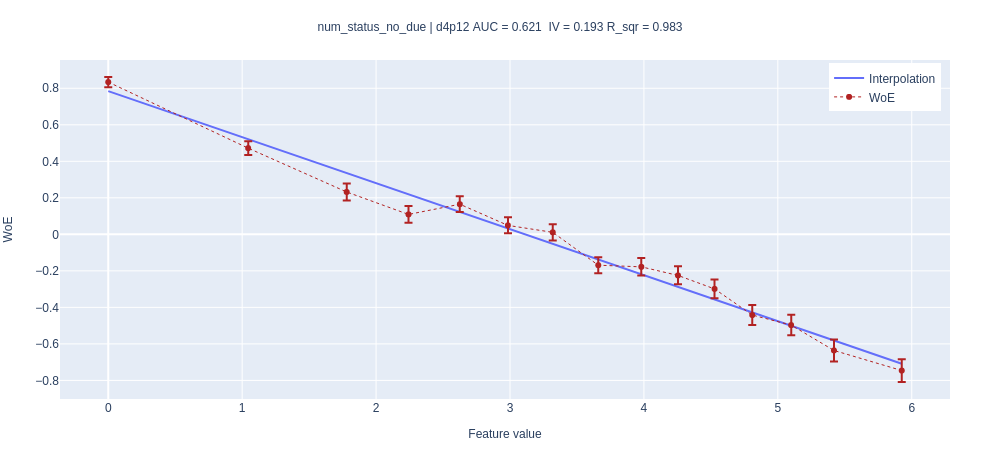

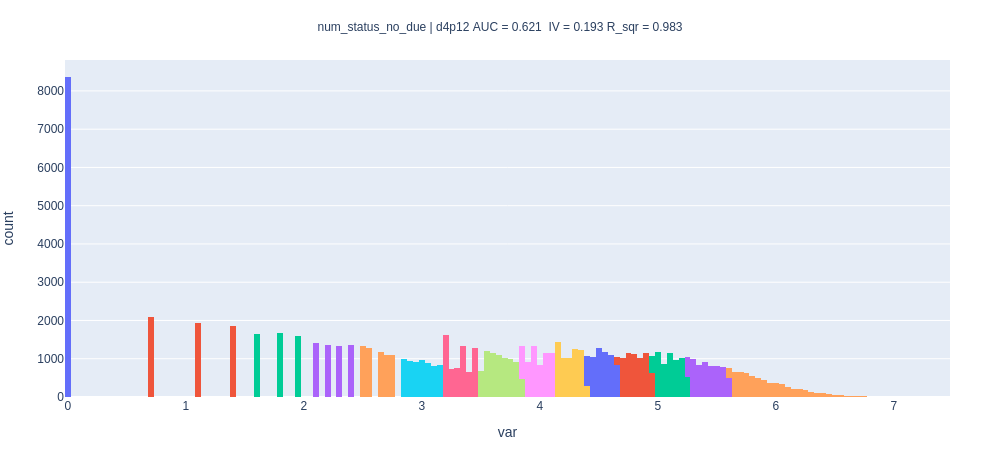

In [ ]:
woe_line(
    var=np.log(df.loc[df.sample_part == 'Train']['num_status_no_due']),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='num_status_no_due',
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )
df['num_status_no_due'] = np.log(df['num_status_no_due'])

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



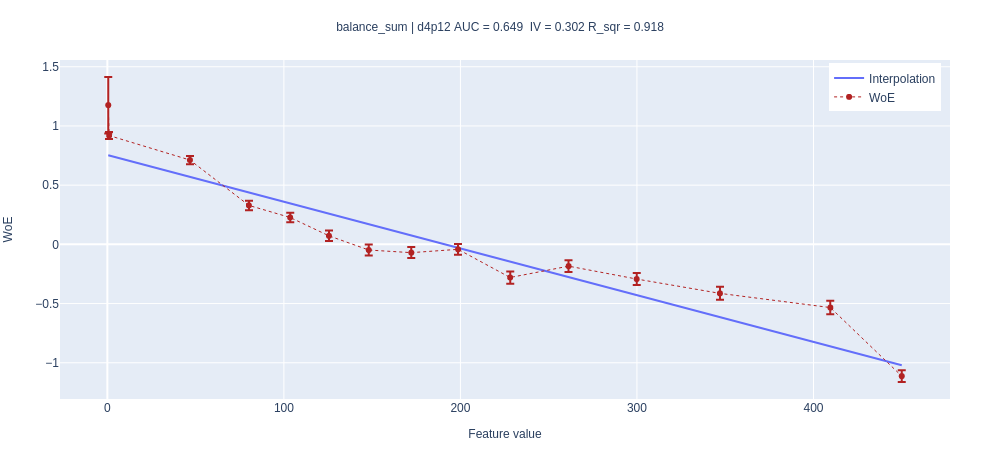

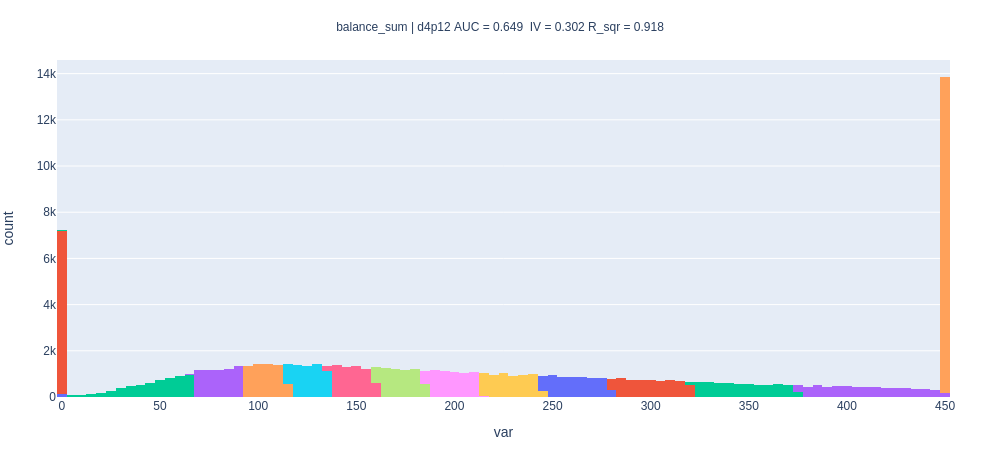

In [ ]:
right_bound = 450

woe_line(
    var=np.minimum(np.sqrt(df.loc[df.sample_part == 'Train']['balance_sum']), right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='balance_sum',
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )

df['balance_sum'] = np.minimum(np.sqrt(df['balance_sum']), right_bound)

Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



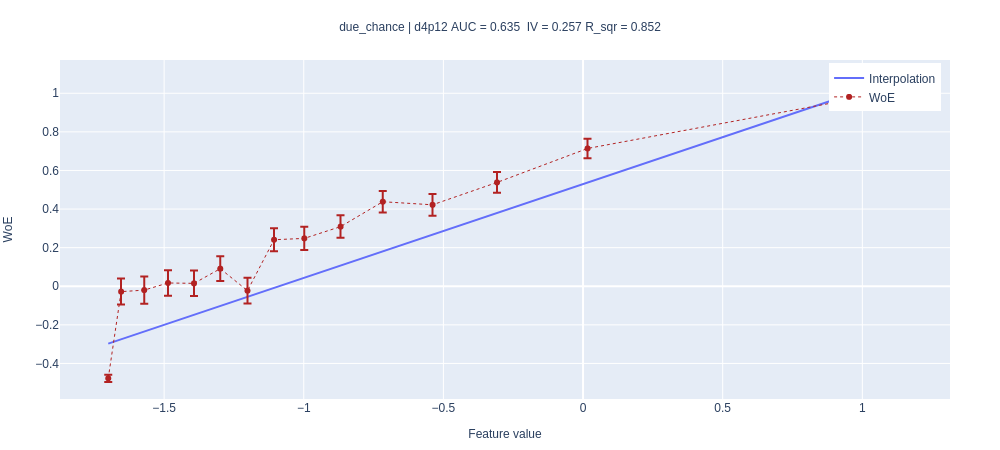

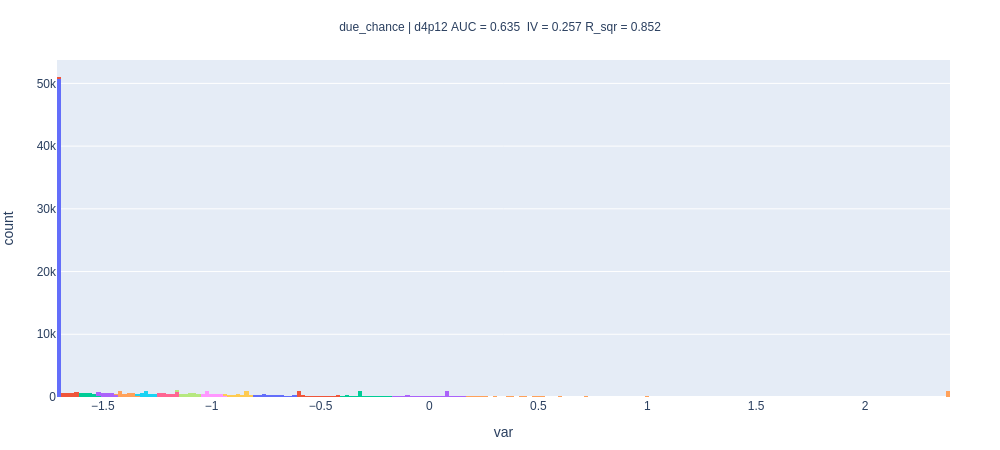

In [ ]:
right_bound = np.quantile(np.log(df.loc[df.sample_part == 'Train']['due_chance']).dropna(), 0.99)
left_bound = -1.7

woe_line(
    var=np.clip(np.log(df.loc[df.sample_part == 'Train']['due_chance']), left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='due_chance',
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )

df['due_chance'] = np.clip(np.log(df['due_chance']), left_bound, right_bound)

Удалено 21717 строк с нуллами, осталось 94434
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



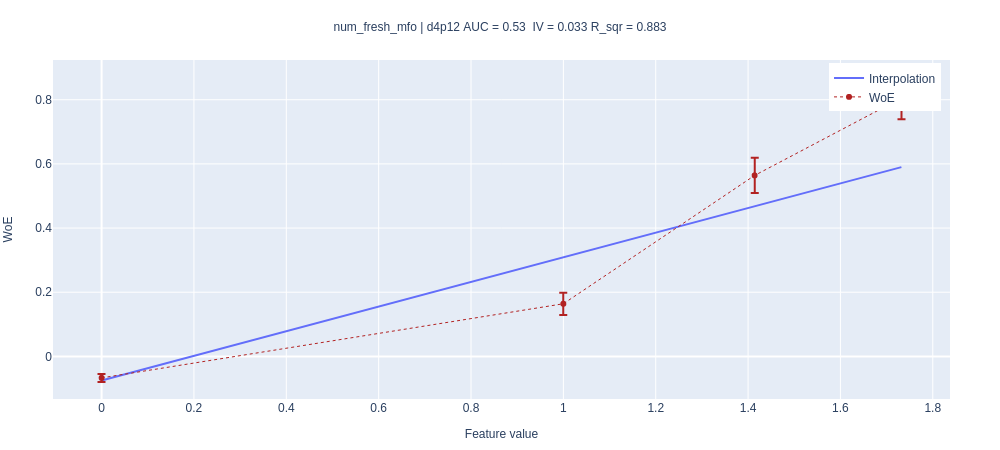

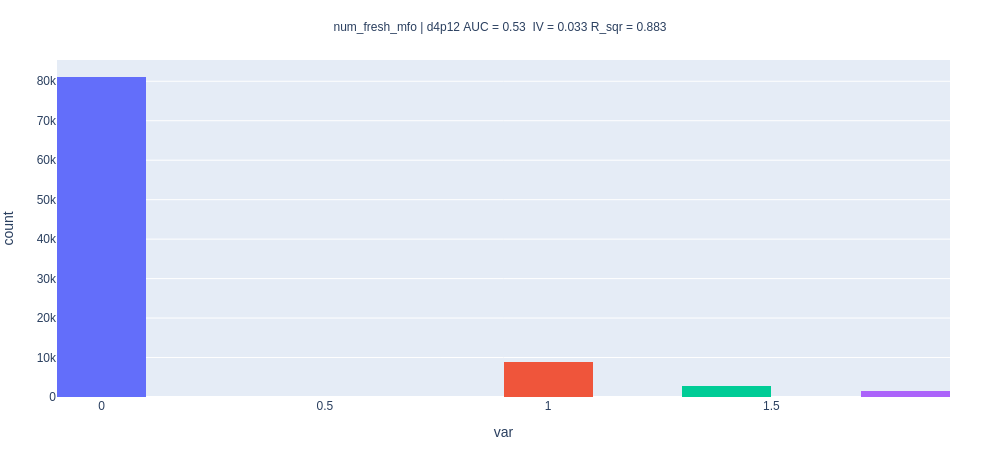

In [ ]:
right_bound = np.quantile(np.sqrt(df.loc[df.sample_part == 'Train']['num_fresh_mfo']).dropna(), 0.99)

woe_line(
    var=np.minimum(np.sqrt(df.loc[df.sample_part == 'Train']['num_fresh_mfo']), right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='num_fresh_mfo',
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )

df['num_fresh_mfo'] = np.minimum(np.sqrt(df['num_fresh_mfo']), right_bound)

In [ ]:
left_bound = 5.6
right_bound = 6.6

woe_line(
    var=np.clip(np.log(df.loc[df.sample_part == 'Train']['debet_score']), left_bound, right_bound),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='debet_score',
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )

df['debet_score'] = np.clip(np.log(df['debet_score']), left_bound, right_bound)

KeyboardInterrupt: ignored

In [ ]:
feature_names.remove('age')

Удалено 2437 строк с нуллами, осталось 113714
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



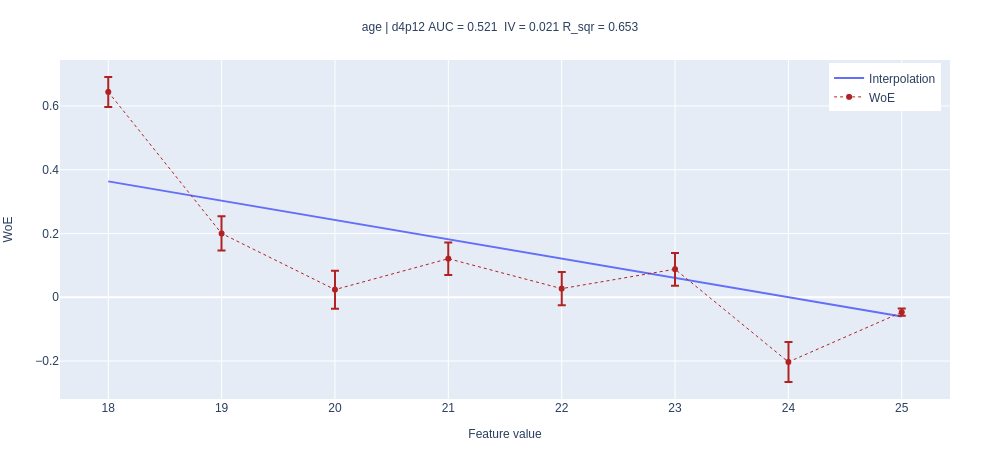

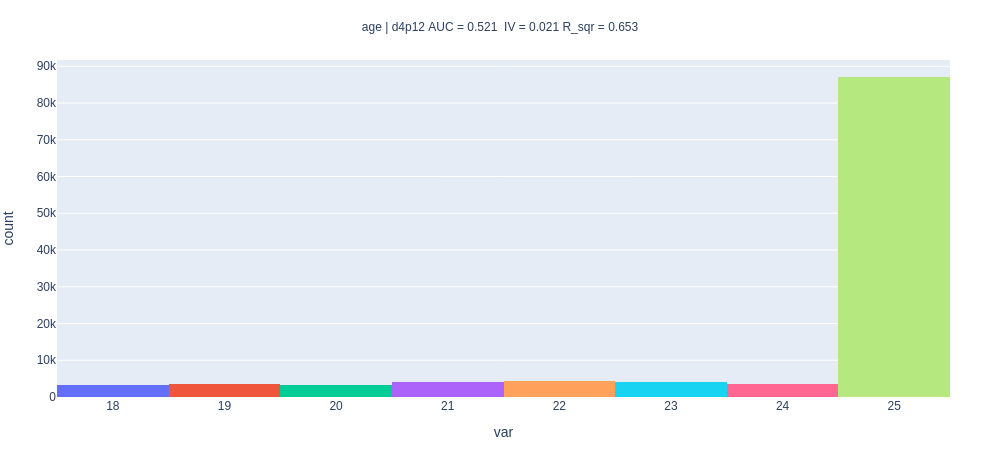

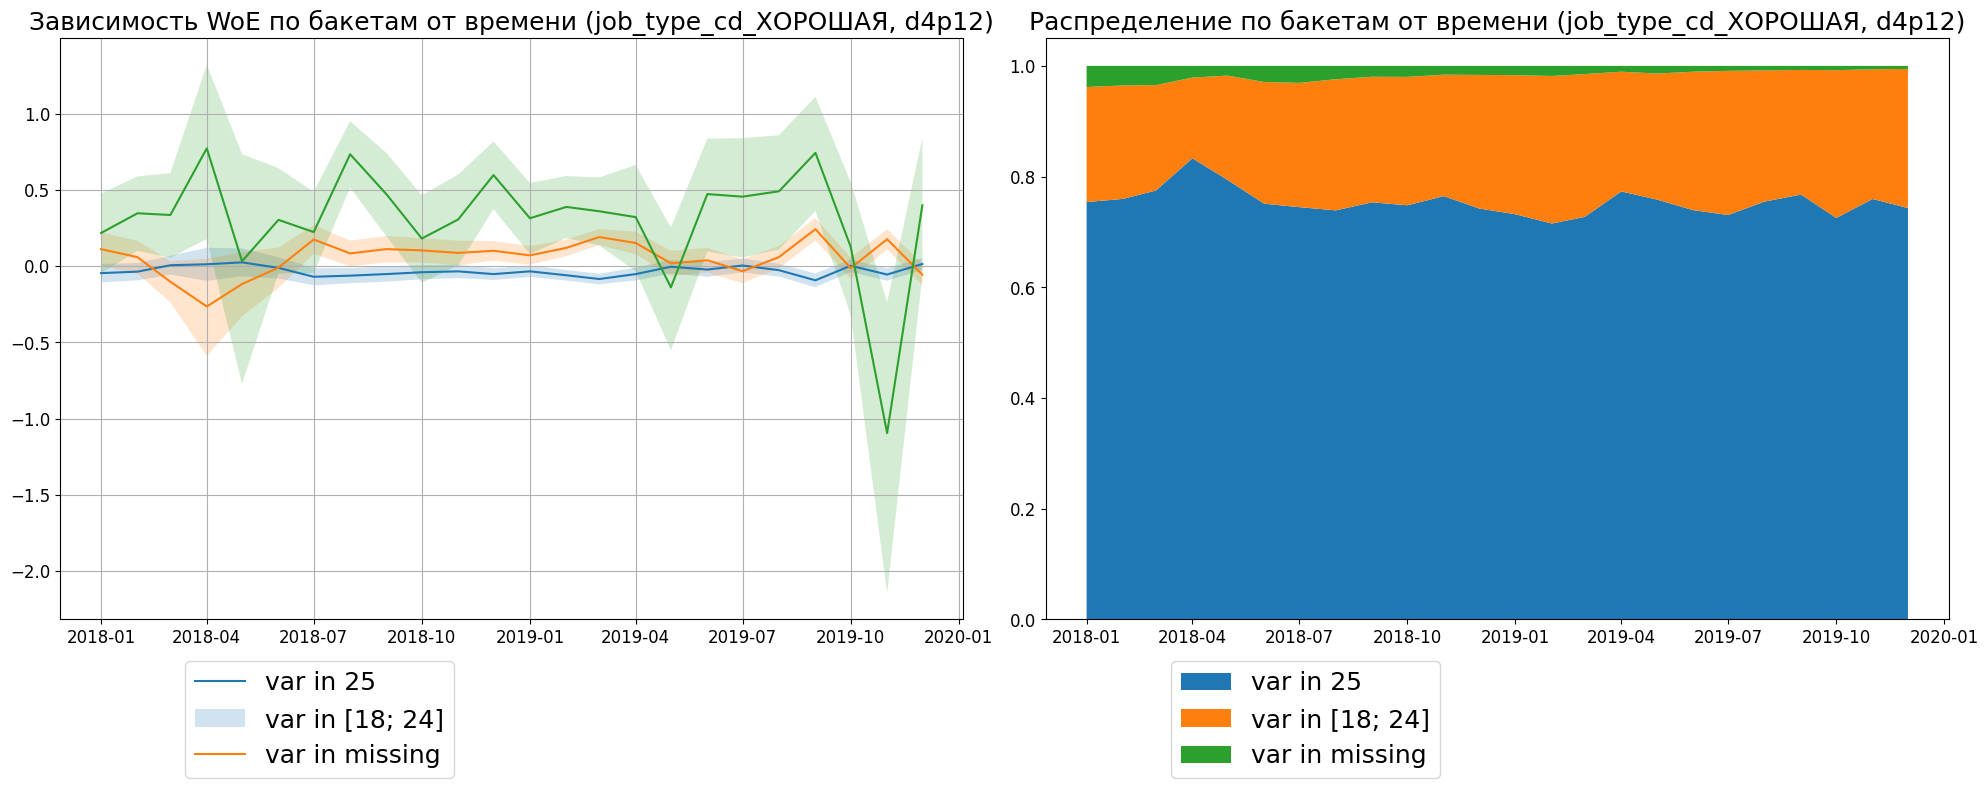

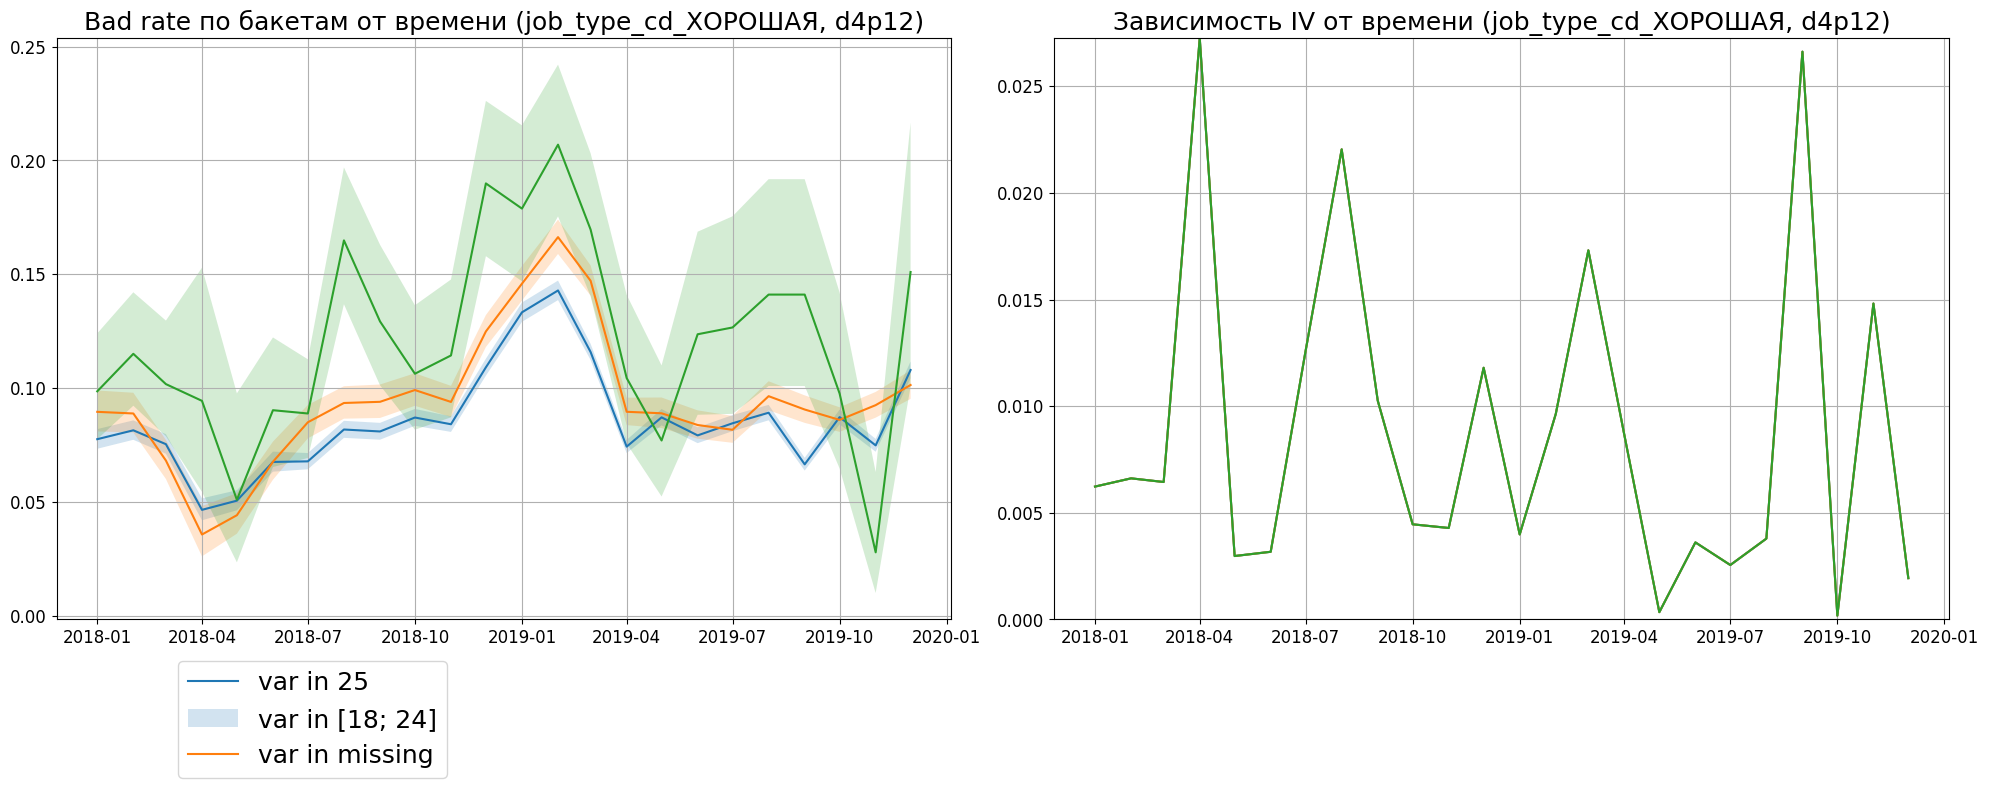

In [ ]:
woe_line(
    var=np.clip(df.loc[df.sample_part == 'Train']['age'], 18, 25),
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='age',
    target_nm='d4p12',
    plot_line=True,
    plot_hist=True
  )
woe_stab(
    var=np.clip(df['age'], 18, 25),
    Nvar=2,
    time=df['month_dt'],
    bad=df['d4p12'],
    varname=feature_name,
    target='d4p12'
)
df['age'] = np.clip(df['age'], 18, 25)

In [ ]:
df[feature_names].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194366 entries, 0 to 194365
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   outstanding_rate                  126363 non-null  float64
 1   num_status_no_due                 159377 non-null  float64
 2   balance_sum                       159377 non-null  float64
 3   due_chance                        159377 non-null  float64
 4   num_fresh_mfo                     159377 non-null  float64
 5   bki_score                         192055 non-null  float64
 6   telecom1_score                    35749 non-null   float64
 7   telecom2_score                    154961 non-null  float64
 8   partner1_score                    151526 non-null  float64
 9   debet_score                       57081 non-null   float64
 10  no_due_and_short_history_flg_1.0  194366 non-null  uint8  
 11  mfo_flg_1.0                       194366 non-null  u

In [ ]:
# проанализируем nan флаги для признаков с nan

features_with_nan = ['outstanding_rate', 
                     'num_status_no_due', 
                     'balance_sum',
                     'due_chance',
                     'num_fresh_mfo',
                     'bki_score',
                     'telecom1_score',
                     'telecom2_score',
                     'partner1_score',
                     'debet_score',
                     'age']
                     
for feature_name in features_with_nan:
  new_name = f'{feature_name}_null_flg'
  display(Markdown('<h2>' + new_name + '<h2>'))
  
  df[new_name] = df[feature_name].isna().astype(int)

  res = woe_stab(
    var=df[new_name],
    Nvar=2,
    time=df['month_dt'],
    bad=df['d4p12'],
    varname=new_name,
    target='d4p12'
  )
  print(res)

In [ ]:
feature_names.append('telecom2_score_null_flg') 
feature_names.append('partner1_score_null_flg') 
feature_names.append('debet_score_null_flg')


In [ ]:
# заполним пропуски

lr_filler = WoEFiller()

lr_filler.fit(
    X = df.loc[df.sample_part == 'Train'][features_with_nan],
    y = df.loc[df.sample_part == 'Train']['d4p12'],
    method='zero_woe'
)

df_transformed = lr_filler.transform(df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1

In [ ]:
df_transformed[feature_names].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194366 entries, 0 to 194365
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   outstanding_rate                  194366 non-null  float64
 1   num_status_no_due                 194366 non-null  float64
 2   balance_sum                       194366 non-null  float64
 3   due_chance                        194366 non-null  float64
 4   num_fresh_mfo                     194366 non-null  float64
 5   bki_score                         194366 non-null  float64
 6   telecom1_score                    194366 non-null  float64
 7   telecom2_score                    194366 non-null  float64
 8   partner1_score                    194366 non-null  float64
 9   debet_score                       194366 non-null  float64
 10  no_due_and_short_history_flg_1.0  194366 non-null  uint8  
 11  mfo_flg_1.0                       194366 non-null  u

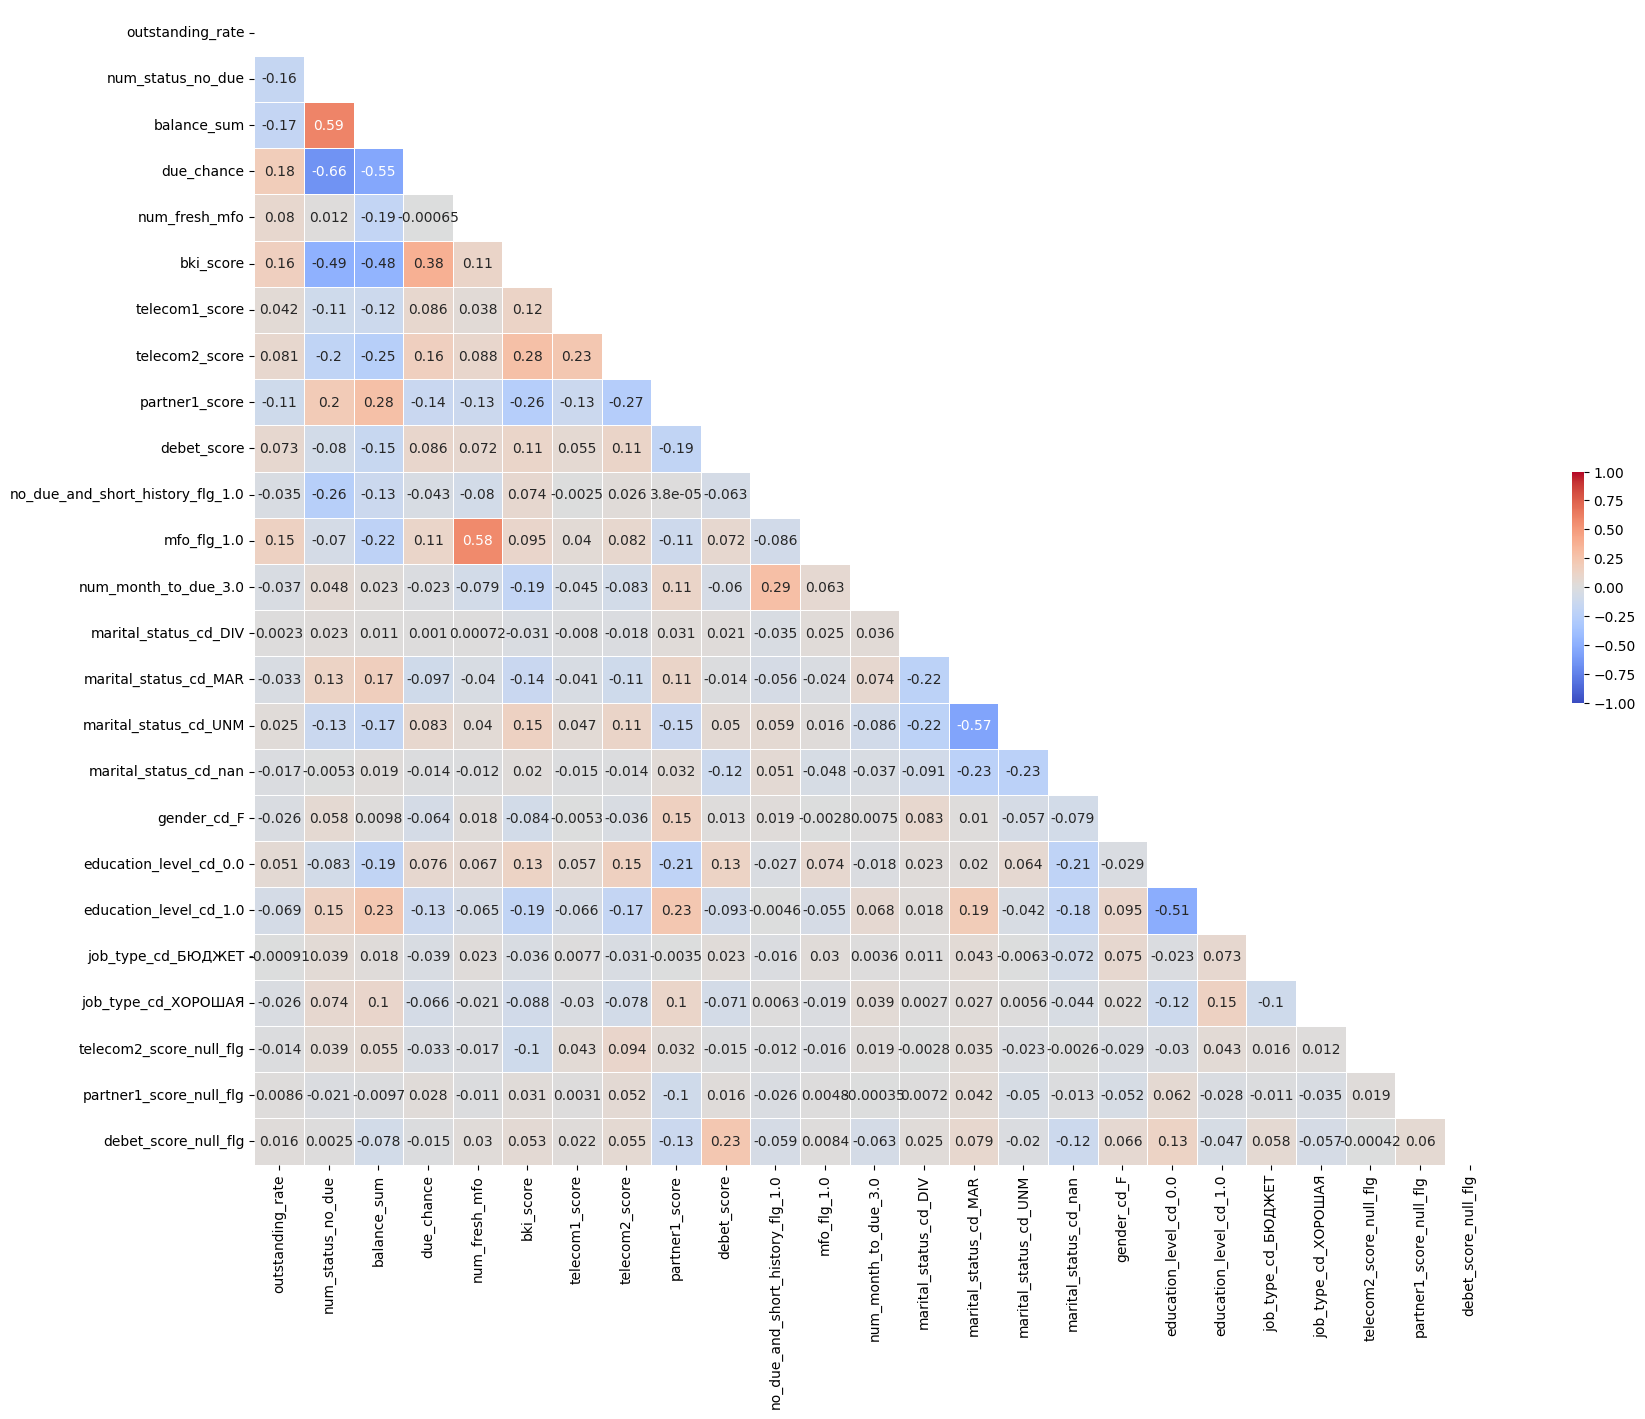

In [ ]:
# матрица корреляций 

corr = df_transformed.loc[df_transformed.sample_part == 'Train', feature_names].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            linewidths=.5, cbar_kws={"shrink": .2})
plt.show()

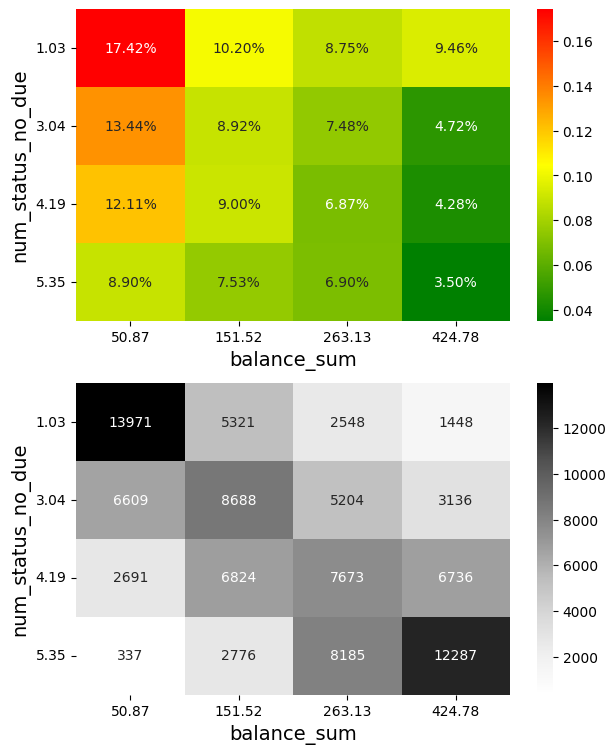

In [ ]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['num_status_no_due'],
    var_2=df.loc[df.sample_part == 'Train']['balance_sum'],
    target='d4p12',
    name_1='num_status_no_due',
    name_2='balance_sum',
    nbuck_1=4,
    nbuck_2=4,
    null_buck_1=False,
    null_buck_2=False, 
    median=True
)
#feature_names.remove('num_fresh_mfo')

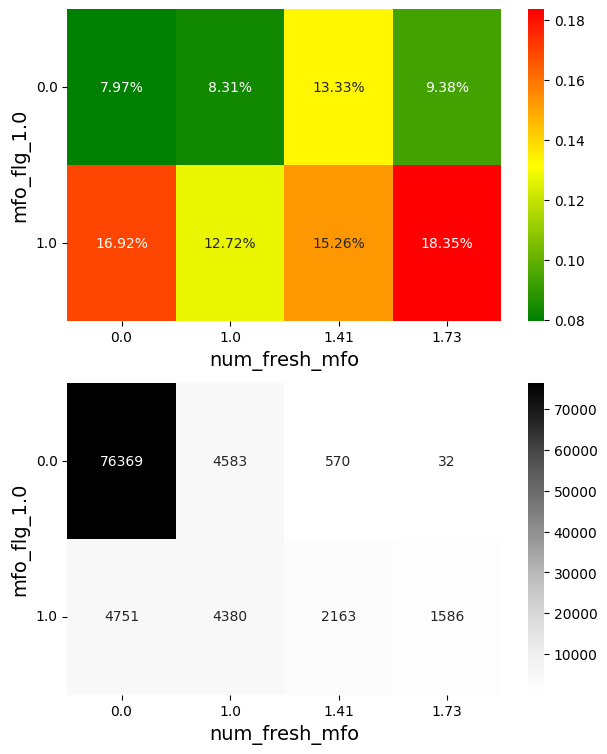

In [ ]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['mfo_flg_1.0'],
    var_2=df.loc[df.sample_part == 'Train']['num_fresh_mfo'],
    target='d4p12',
    name_1='mfo_flg_1.0',
    name_2='num_fresh_mfo',
    nbuck_1=2,
    nbuck_2=4,
    null_buck_1=False,
    null_buck_2=False, 
    median=True
)
feature_names.remove('num_fresh_mfo')

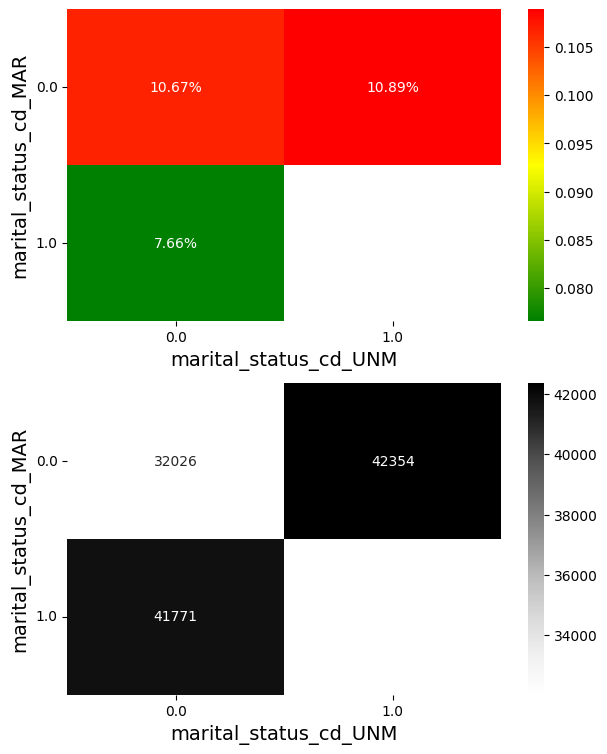

In [ ]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['marital_status_cd_MAR'],
    var_2=df.loc[df.sample_part == 'Train']['marital_status_cd_UNM'],
    target='d4p12',
    name_1='marital_status_cd_MAR',
    name_2='marital_status_cd_UNM',
    nbuck_1=2,
    nbuck_2=2,
    null_buck_1=False,
    null_buck_2=False, 
    median=True
)
feature_names.remove('marital_status_cd_UNM')

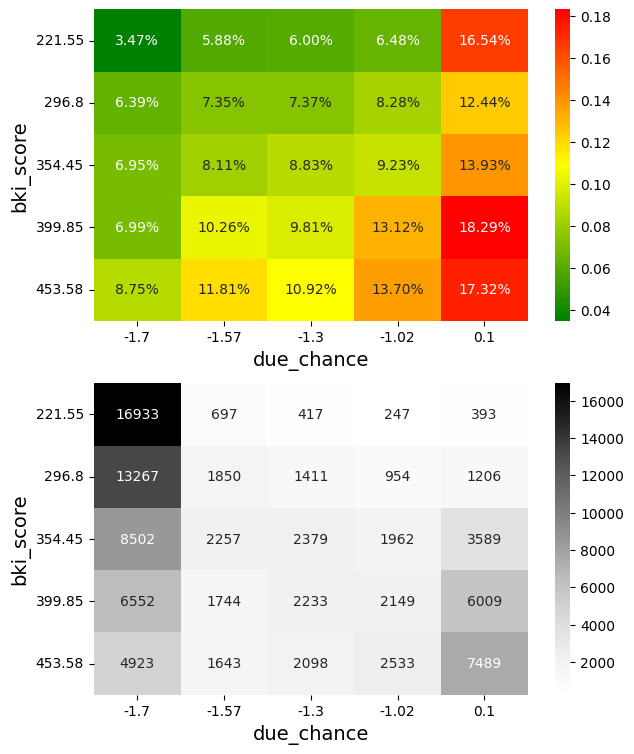

In [ ]:
crosstab(
    bad=df.loc[df.sample_part == 'Train']['d4p12'],
    var_1=df.loc[df.sample_part == 'Train']['bki_score'],
    var_2=df.loc[df.sample_part == 'Train']['due_chance'],
    target='d4p12',
    name_1='bki_score',
    name_2='due_chance',
    nbuck_1=5,
    nbuck_2=5,
    null_buck_1=False,
    null_buck_2=False, 
    median=True
)

In [ ]:
# обучение

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # Для приведения признаков к одному масштабу
from sklearn.pipeline import make_pipeline

lr_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='none', max_iter=500, solver='saga')
)

lr_pipeline.fit(
    X=df_transformed.loc[df_transformed.sample_part == 'Train', feature_names],
    y=df_transformed.loc[df_transformed.sample_part == 'Train']['d4p12']
)

df['pd_model'] = lr_pipeline.predict_proba(df_transformed[feature_names])[:, 1]
df['pd_model'].head()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



0    0.186760
1    0.091359
2    0.024219
3    0.019880
4    0.006014
Name: pd_model, dtype: float64

In [ ]:
feature_coef = pd.DataFrame({
    'feature': feature_names,
    'coef': lr_pipeline[1].coef_[0],
    'mean': lr_pipeline[0].mean_,
    'std': lr_pipeline[0].scale_
}).sort_values(by='coef', key=abs, ascending=False)

print(feature_coef.round(3))

woe_coef = []

for id in feature_coef.index:
  print(feature_coef['feature'][id])
  res = woe_line(
    var=df.loc[df.sample_part == 'Train'][feature_coef['feature'][id]],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm=feature_coef['feature'][id],
    target_nm='d4p12',
    plot_line=False,
    plot_hist=False
  )
  woe_coef.append(res['coef'])
feature_coef['woe_coef'] = woe_coef
feature_coef.round(3)

                             feature   coef     mean      std
6                     telecom2_score  0.273    1.375    0.381
8                        debet_score  0.271    6.321    0.122
7                     partner1_score -0.250   -3.216    0.317
0                   outstanding_rate  0.182    0.557    0.145
3                         due_chance  0.156   -1.209    0.726
22              debet_score_null_flg  0.154    0.751    0.433
21           partner1_score_null_flg  0.133    0.224    0.417
4                          bki_score  0.123  355.616   81.617
2                        balance_sum -0.117  216.698  129.793
11              num_month_to_due_3.0 -0.100    0.640    0.480
18                job_type_cd_БЮДЖЕТ -0.088    0.095    0.293
17            education_level_cd_1.0 -0.079    0.298    0.457
9   no_due_and_short_history_flg_1.0 -0.078    0.127    0.333
5                     telecom1_score  0.078   -2.768    0.125
15                       gender_cd_F -0.075    0.439    0.496
10      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



debet_score
Удалено 87202 строк с нуллами, осталось 28949


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



partner1_score
Удалено 26015 строк с нуллами, осталось 90136


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



outstanding_rate
Удалено 41722 строк с нуллами, осталось 74429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



due_chance
Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



debet_score_null_flg
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



partner1_score_null_flg
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



bki_score
Удалено 2254 строк с нуллами, осталось 113897


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



balance_sum
Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



num_month_to_due_3.0
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



job_type_cd_БЮДЖЕТ
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



education_level_cd_1.0
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



no_due_and_short_history_flg_1.0
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



telecom1_score
Удалено 94705 строк с нуллами, осталось 21446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



gender_cd_F
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



mfo_flg_1.0
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



telecom2_score_null_flg
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



marital_status_cd_MAR
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



marital_status_cd_DIV
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



job_type_cd_ХОРОШАЯ
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



education_level_cd_0.0
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



marital_status_cd_nan
n_buckets 15 reduced to 14
n_buckets 14 reduced to 13
n_buckets 13 reduced to 12
n_buckets 12 reduced to 11
n_buckets 11 reduced to 10
n_buckets 10 reduced to 9
n_buckets 9 reduced to 8
n_buckets 8 reduced to 7
n_buckets 7 reduced to 6
n_buckets 6 reduced to 5
n_buckets 5 reduced to 4
n_buckets 4 reduced to 3
n_buckets 3 reduced to 2


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



num_status_no_due
Удалено 21717 строк с нуллами, осталось 94434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



,feature,coef,mean,std,woe_coef
6,telecom2_score,0.273,1.375,0.381,0.530
8,debet_score,0.271,6.321,0.122,0.777
7,partner1_score,-0.250,-3.216,0.317,-0.539
0,outstanding_rate,0.182,0.557,0.145,0.414
3,due_chance,0.156,-1.209,0.726,0.390
22,debet_score_null_flg,0.154,0.751,0.433,0.165
21,partner1_score_null_flg,0.133,0.224,0.417,0.157
4,bki_score,0.123,355.616,81.617,0.458
2,balance_sum,-0.117,216.698,129.793,-0.565
11,num_month_to_due_3.0,-0.100,0.640,0.480,-0.158


In [ ]:
bad_coef = ['age']
feature_names.remove('age')

ValueError: ignored

In [ ]:
sns.barplot(data=feature_coef, x='coef', y='feature', orient='h')
plt.show()

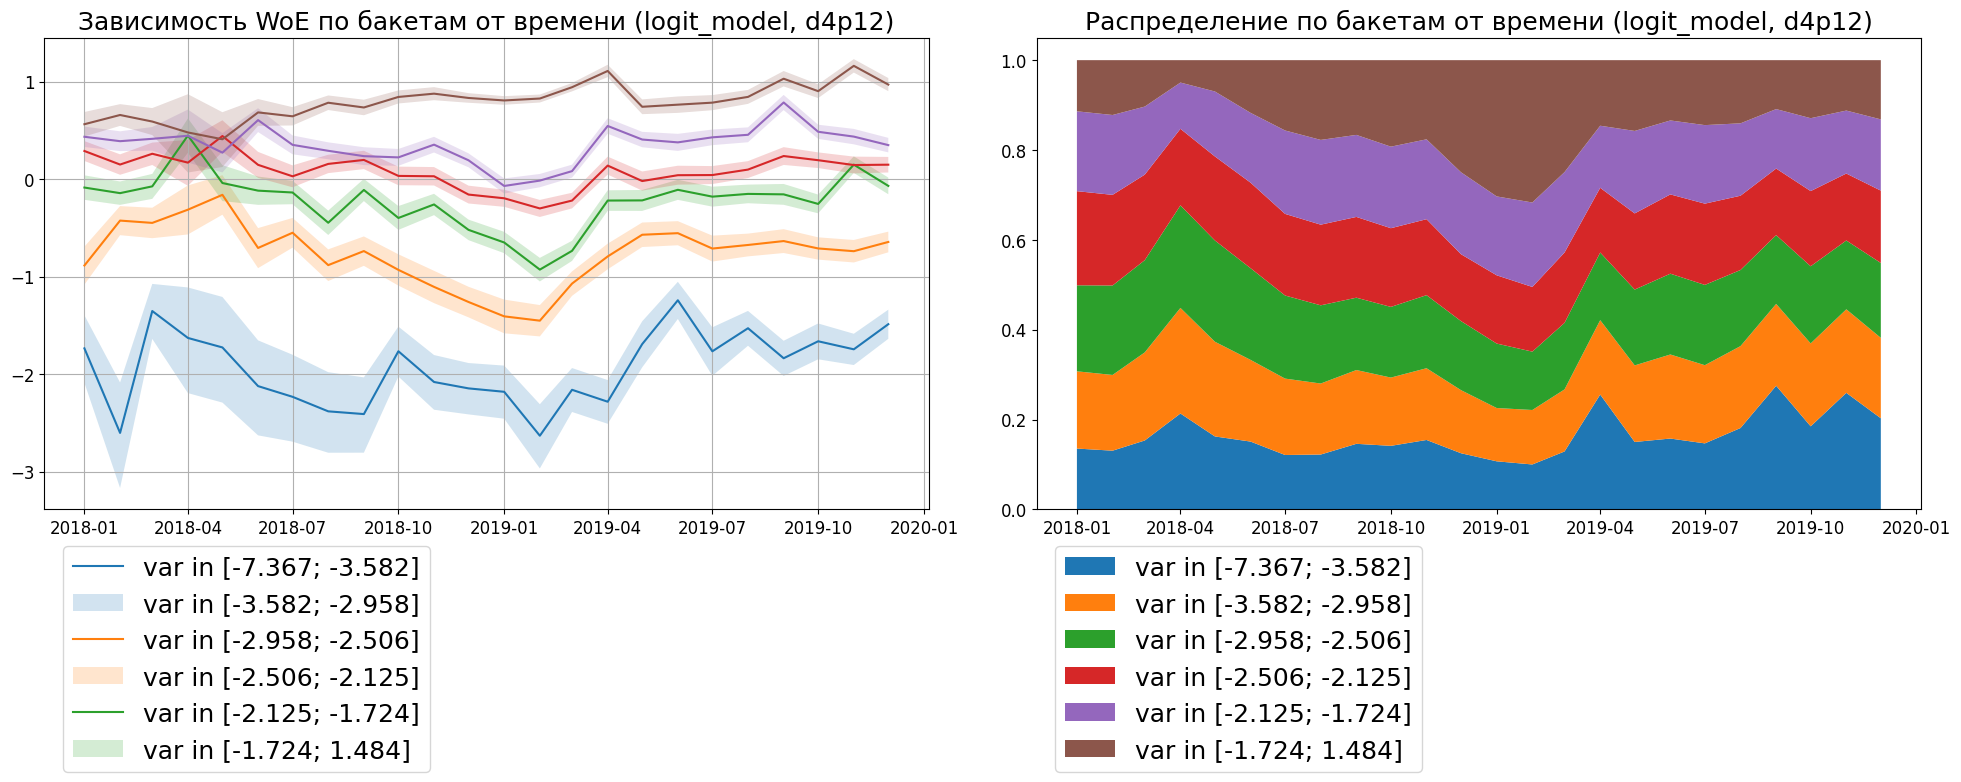

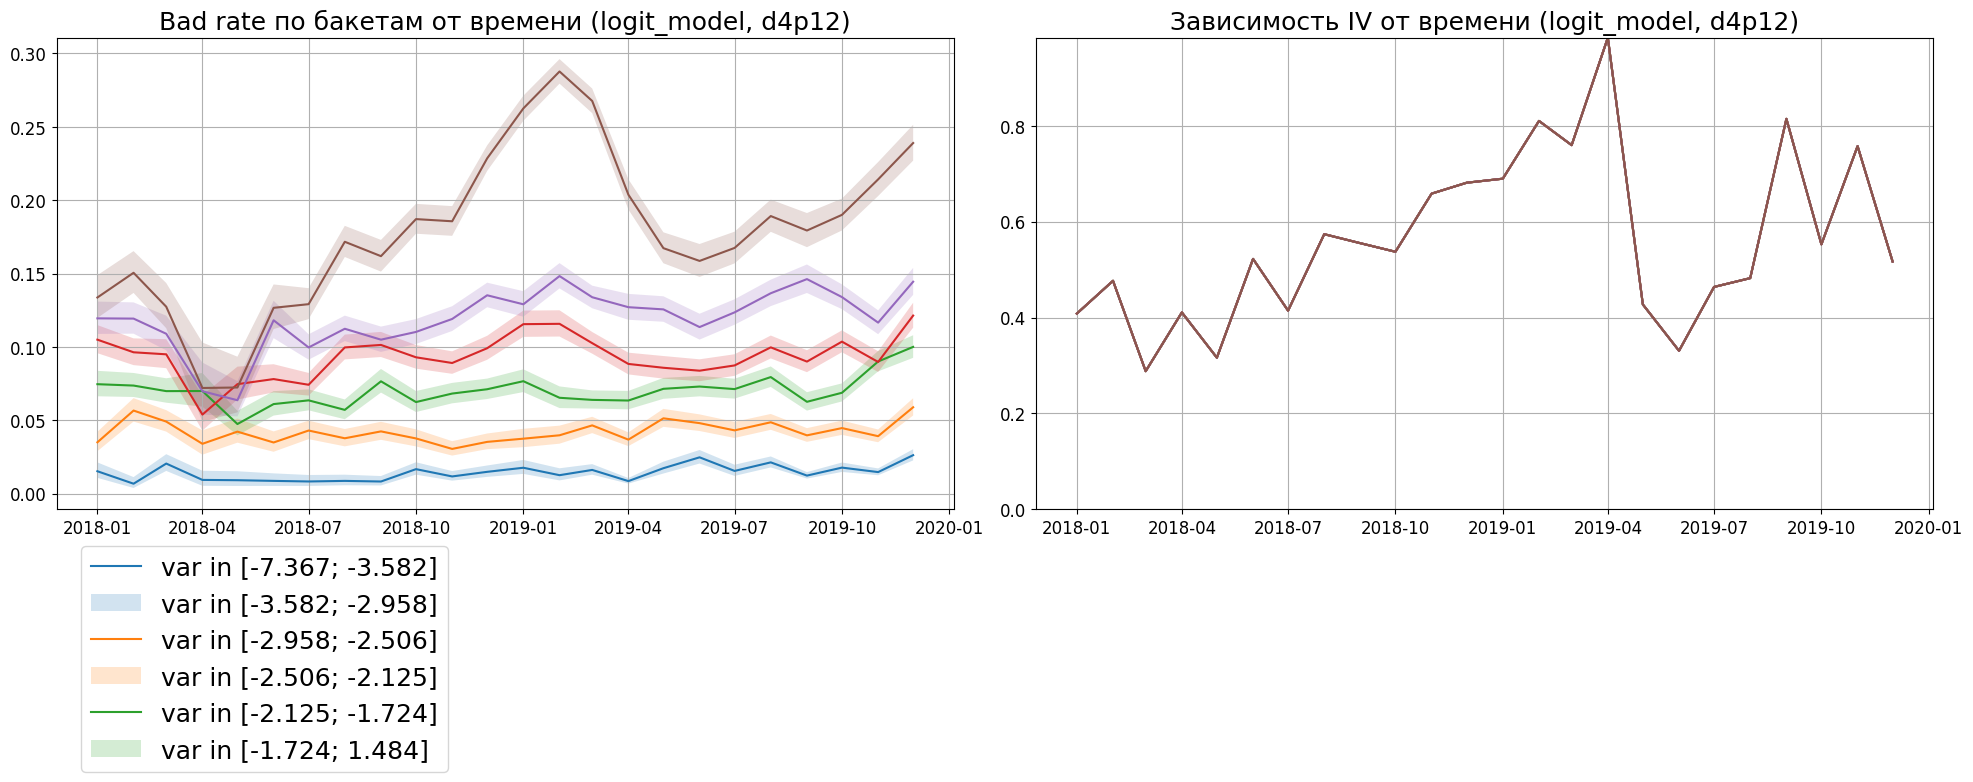

array([0.40825439, 0.47666128, 0.28821067, 0.41073053, 0.31632552,
       0.52230969, 0.41446138, 0.57387382, 0.55502891, 0.53721845,
       0.65841007, 0.68114142, 0.68958951, 0.81001637, 0.75949664,
       0.98356372, 0.42733636, 0.33071029, 0.46384983, 0.48222475,
       0.81437053, 0.55265981, 0.75741851, 0.51682944])

In [ ]:
from scipy.special import logit

# применим функцию logit к предсказанным вероятностям

df['logit_model'] = logit(df['pd_model'])

woe_stab(
    var=df['logit_model'],
    Nvar=6, 
    time=df['month_dt'],
    bad=df['d4p12'],
    varname='logit_model',
    target='d4p12'
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



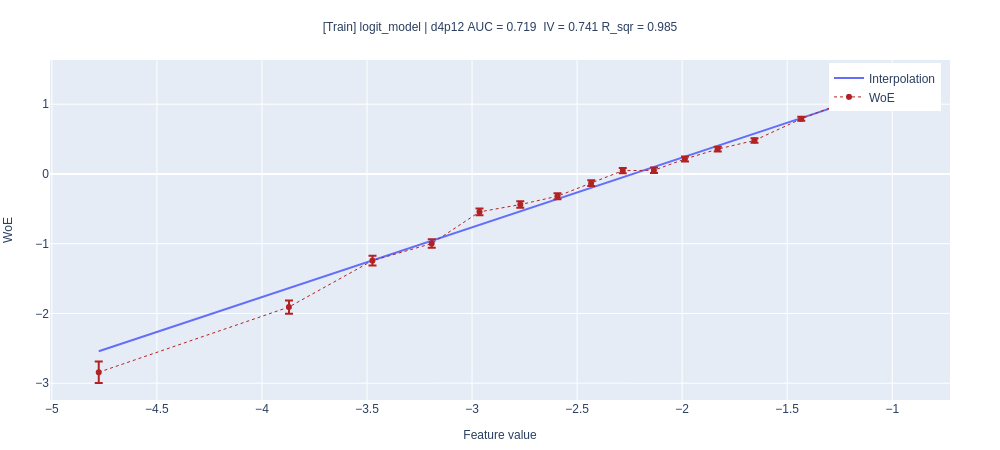

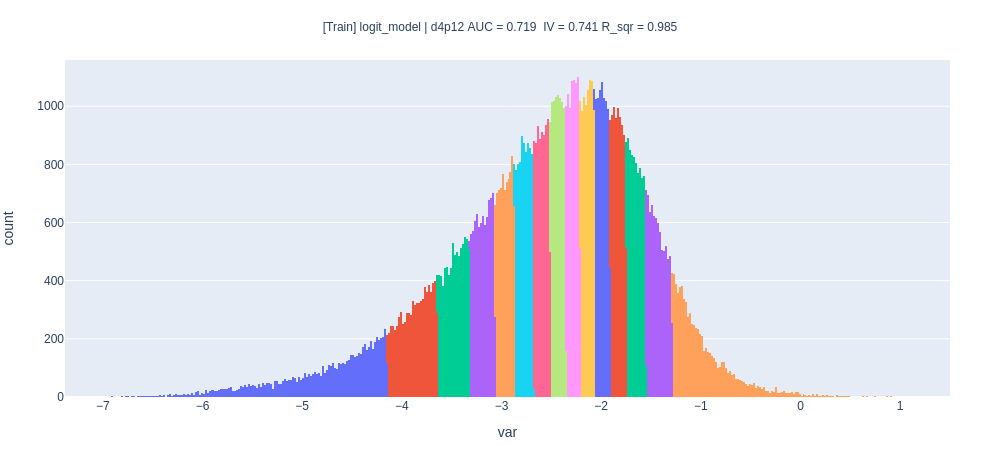

{'AUC': 0.719,
 'IV': 0.741,
 'R_sqr': 0.985,
 'n_obs': 116151,
 'n_buckets': 15,
 'coef': 0.9774281769560617}

In [ ]:
woe_line(
    var=df.loc[df.sample_part == 'Train']['logit_model'],
    target=df.loc[df.sample_part == 'Train']['d4p12'],
    n_buckets=15,
    var_nm='[Train] logit_model',
    target_nm='d4p12',
    plot_hist=True
)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.



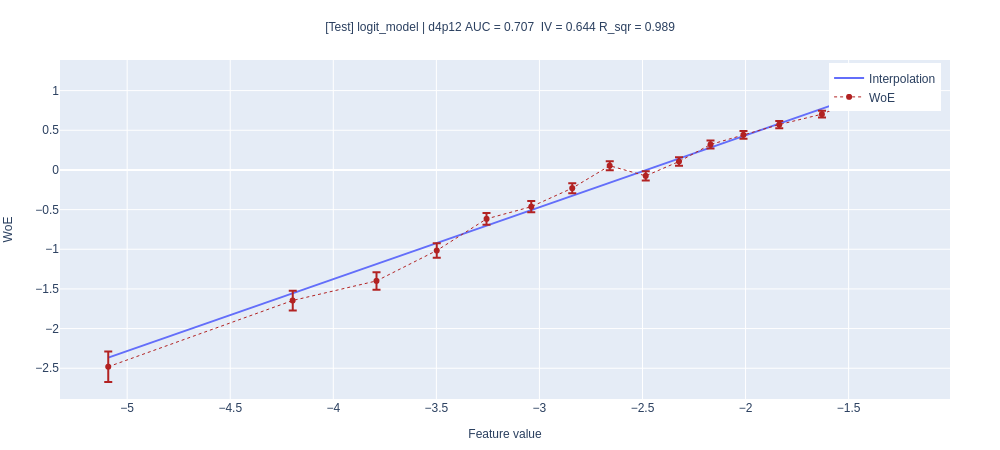

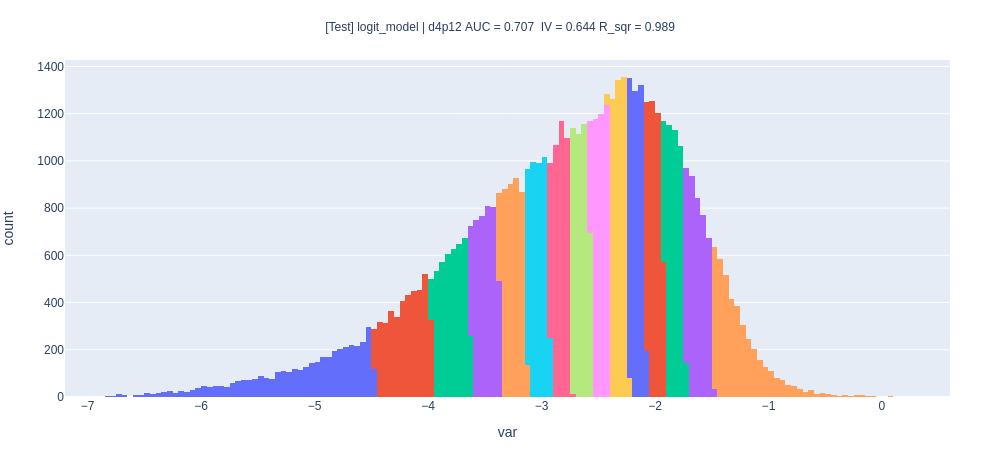

{'AUC': 0.707,
 'IV': 0.644,
 'R_sqr': 0.989,
 'n_obs': 61299,
 'n_buckets': 15,
 'coef': 0.9188193818720494}

In [ ]:
woe_line(
    var=df.loc[df.sample_part == 'Test']['logit_model'],
    target=df.loc[df.sample_part == 'Test']['d4p12'],
    n_buckets=15,
    var_nm='[Test] logit_model',
    target_nm='d4p12',
    plot_hist=True
)

In [ ]:
from model_tools import plot_metric_time

plot_metric_time(
    df=df,
    features=['pd_model'],
    target='d4p12',
    time='month_dt',
    ttl='Качество модели во времени'
)

In [ ]:
df['sample_part_num'] = df['sample_part']
df.loc[df.sample_part == 'Train', 'sample_part_num'] = '1) Train'
df.loc[df.sample_part == 'Validation', 'sample_part_num'] = '2) Validation'
df.loc[df.sample_part == 'Test', 'sample_part_num'] = '3) Test'


plot_metric_time(
    df=df,
    features=['pd_model'],
    target='d4p12',
    time='sample_part_num',
    ttl='Качество модели по частям выборки'
).round(3)

In [ ]:
from model_tools import forward_selection

features_selected = forward_selection(
    Q=df_transformed.loc[df_transformed.sample_part == 'Train', feature_names],
    y=df_transformed.loc[df_transformed.sample_part == 'Train', 'd4p12'],
    threshold_in=0.01 
)